# Demonstration of applying weighted shap value technique to decision tree based ML models

In [1]:
# Importing Required Libraries
import numpy as np
import numpy.random as npr
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

## Create the coefficients for the (non)linear model underlying the data generation process

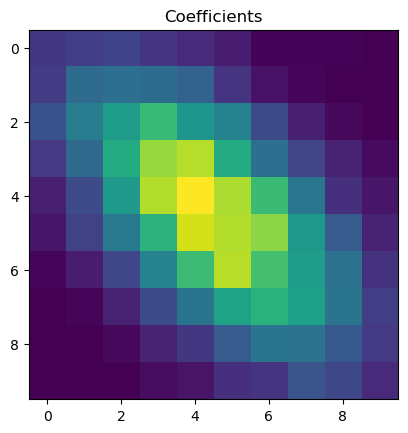

In [2]:
npr.seed(10)
X = npr.multivariate_normal(np.zeros(10), np.eye(10), size=int(1e5))

# Method 1
scatter = npr.multivariate_normal(mean=np.zeros(2), cov=[[1,0.6],[0.6,1]], size=10000)

# Plot scatter on which method 1 is based
# plt.figure()
# plt.scatter(scatter[:,0], scatter[:,1], s=1)

hist = np.histogram2d(scatter[:,0], scatter[:,1], range=([-2,2],[-2,2]), bins=10)
coefs = hist[0]

#Method 2
# coefs = sum([np.eye(10, k=k)*(10-abs(k)) for k in range(-10,10)])

plt.figure()
plt.imshow(coefs)
plt.title('Coefficients')

plt.show()

## Apply linear transform and optionally nonlinear one

In [3]:
# Apply linear and optionally a non-linear transform to x data

# linear transform
Y = X @ coefs

# optionally add non-linear transform
Y = np.exp(Y/Y.max())
# Y = Y**3

Y.shape

(100000, 10)

## Define and fit ML model: GBT or RF

In [4]:
# model = RandomForestRegressor()
model = MultiOutputRegressor(HistGradientBoostingRegressor(), n_jobs=4)
model.fit(X, Y)

print('R2 score: ', r2_score(model.predict(X), Y))

R2 score:  0.9916620200177586


## Calculate SHAP values

In [5]:
from shap import TreeExplainer, KernelExplainer, Explainer
from convection_param.shap_values.ShapMultiOutputRegressor import MultiOutputTreeExplainer, build_tree_explainer

# This class is used for the Multioutput Regressor
class MultiOutputTreeExplainer(Explainer):
    """ Abstraction of Explainer for MultiOutputRegressor model
    """
    def __init__(self, model, *args, **kwargs):
        assert isinstance(model, MultiOutputRegressor)
        self.explainers = []
        self.expected_value = []
        for estimator in model.estimators_:
            explainer = TreeExplainer(estimator, *args, **kwargs)
            self.explainers.append(explainer)
            self.expected_value.append(explainer.expected_value)

    def shap_values(self, *args, **kwargs):
        shap_values = []
        for explainer in self.explainers:
            shap_values.append(explainer.shap_values(*args, **kwargs))
        return np.array(shap_values)

In [6]:
%%time
# Calculate shap values for a subset of 300 samples
npr.seed(745)
random_idx = npr.choice(X.shape[0], size=300, replace=False)
X_explain = X[random_idx]

# For GBT
explainer = MultiOutputTreeExplainer(model)
# For RF
# explainer = TreeExplainer(model)

shap_values = np.array(explainer.shap_values(X_explain))
shap_values.shape, X_explain.shape

CPU times: user 1.69 s, sys: 5.45 ms, total: 1.69 s
Wall time: 1.7 s


((10, 300, 10), (300, 10))

## Apply weighted averaging

In [7]:
multiplier = X_explain - np.mean(X_explain, axis=0)
multiplier /= np.maximum(np.max(np.abs(multiplier), axis=0), 0)
mean_shap_values3d = np.mean(multiplier * shap_values, axis=1)
mean_shap_values3d.shape

(10, 10)

## Plot found weights as well as Original weights of linear transform of the data generation process

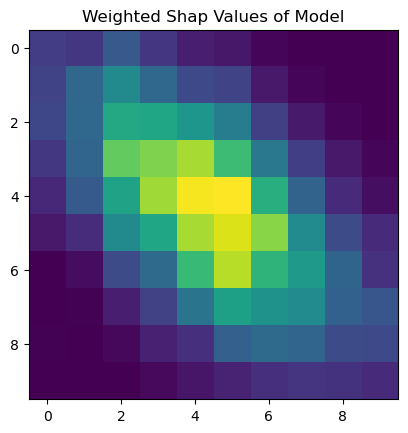

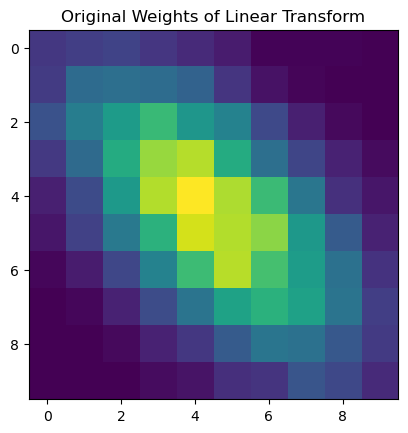

In [8]:
plt.imshow(mean_shap_values3d)
plt.title('Weighted Shap Values of Model')
plt.figure()
plt.imshow(coefs)
plt.title('Original Weights of Linear Transform')
plt.show()